In [1]:
import os
import time

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from transformers import BertTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from src.data_preprocessing import (
    load_data,
    preprocess_data,
    preprocess_blog_data,
    save_processed_data,
)
from src.dataset import SupervisedTextDataset, SupervisedContrastiveTextDataset
from src.contrastive_learning import supervised_contrastive_pretrain
from src.evaluation import evaluate_classifier
from src.model import BertContrastiveModel
from src.supervised_fine_tune import fine_tune_supervised

from src.utils import extract_embeddings, plot_embeddings_tsne

/Users/ndminh/Minh/USA/University/University of Houston/Study/MSCS/Spring 2025/COSC 6342/Project/gender-classification/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to venv/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to venv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to venv/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to venv/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Load and preprocess data
raw_data_path = "data/raw/gender-classification.csv"
processed_data_path = "data/processed"
processed_data_filename = "processed_data.csv"
text_column = "text"
label_column = "gender"

In [3]:
# Load and preprocess external data (blogs data)
external_data_path = "data/raw/blogtext.csv"
processed_external_data_filename = "processed_blog_data.csv"
external_text_column = "text"
external_label_column = "gender"

In [4]:
data_df = load_data(f"{processed_data_path}/{processed_data_filename}")

Data loaded successfully from: data/processed/processed_data.csv


In [5]:
# Texts will be used for contrastive learning
texts = data_df["text"].tolist()
labels = data_df["gender"].tolist()

print("Data loaded and preprocessed.")
print(f"Number of samples: {len(texts)}")
print(f"Number of labels: {len(labels)}")

Data loaded and preprocessed.
Number of samples: 3226
Number of labels: 3226


In [6]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/Users/ndminh/Minh/USA/University/University of Houston/Study/MSCS/Spring 2025/COSC 6342/Project/gender-classification/src/dataset.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.labels[idx], dtype=torch.long)
/Users/ndminh/Minh/USA/University/University of Houston/Study/MSCS/Spring 2025/COSC 6342/Project/gender-classification/venv/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


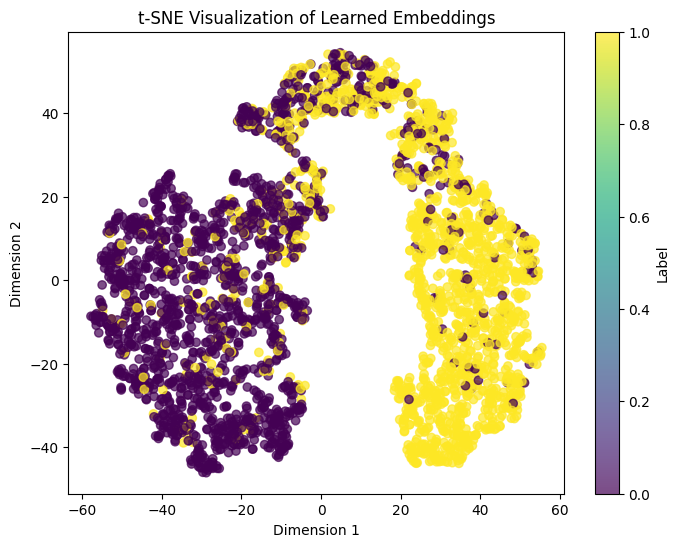

In [9]:
# Create custom datasets for supervised training
# This will not perform data augmentation on the input text samples

supervised_dataset = SupervisedTextDataset(
    texts, labels, tokenizer, max_length=128, augment=False
)

# Split data: 20% as test; from remaining, 20% as validation
total_len = len(supervised_dataset)
test_len = int(0.2 * total_len)
remaining = total_len - test_len
val_len = int(0.2 * remaining)
train_len = remaining - val_len

train_dataset, val_dataset, test_dataset = random_split(
    supervised_dataset, [train_len, val_len, test_len]
)

# batch_size = 8
# # batch_size = 16
# # batch_size = 4
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# print("Data loaded and split into train, validation, and test sets.")

model = BertContrastiveModel(proj_dim=64, num_labels=2, dropout_prob=0.3)
# model = BertContrastiveModel(proj_dim=128, num_labels=2, dropout_prob=0.3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# Load the supervised model weights
supervised_model_path = os.path.join("models", "best_bert_supervised_final_v5.pth")
# supervised_model_path = os.path.join("models", "bert_supervised_contrastive_pretrained_v2.pth")
# Check if the supervised model weights exist
if not os.path.exists(supervised_model_path):
    raise FileNotFoundError(
        f"Supervised model weights not found at {supervised_model_path}. Please run supervised fine-tuning first."
    )

# model.load_state_dict(torch.load(supervised_model_path))


# Load up the model (entire model, not just weights)
model = torch.load(supervised_model_path, weights_only=False)


# Extract embeddings from the dataset
embeddings, labels = extract_embeddings(model, supervised_dataset, device, batch_size=8)

# Plot the embeddings
plot_embeddings_tsne(embeddings, labels, perplexity=30, n_iter=1000)
